In [180]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from functools import reduce
import datetime

In [181]:
def unary(x, C):
    nearest_x = int(np.round(x))
    return((np.r_[np.ones(nearest_x), np.zeros(C-nearest_x)]))

def lsh_hash(point, C):
    # see if I can just vectorize the unary function?
    res = np.concatenate(list(map(lambda x: unary(x, C), point)))
    return(res)

def get_points_in_cluster(idx, clusters, data): # memoize / cache this?
    point_cluster = clusters[idx]
    same_cluster_points_idx = np.where(clusters == point_cluster)[0]
    same_cluster_points = set(map(tuple, data[same_cluster_points_idx, :]))
    return same_cluster_points

def get_point_indices(data, points):
    indices = np.where((data == points[:,None]).all(-1))[1]
    return indices

In [182]:
def data_extend(data, k):
    r, c = data.shape
    data_extend = (reduce(lambda x, y: np.vstack((x, y)), map(lambda x: data, range(k))) +
                  np.random.randn(r*c*k).reshape(r*k, c).round(1))
    return(data_extend)

In [183]:
np.min(iris)

0.0

In [597]:
# set l, k, A, Pmiss?
# figure out how to make dendrogram

iris = datasets.load_iris().data*10
#iris = data_extend(iris, 10) * 10
#iris += np.abs(np.min(iris))
#iris = iris[:,:2]

A = 1.4
l = 10
k = 100
#C = 110
C = int(np.ceil(np.max(iris))) + 1 # maximal coordinate value of any point is less than C
print(C)
n, d = iris.shape
print(n, d)
clusters = np.arange(n)
unique_clusters = len(np.unique(clusters))

# randomly sample sqrt(n) points from data to set initial value for r? or use formula below?
#np.random.seed(12)
n_samp = int(np.ceil(np.sqrt(n)))
samples = iris[np.random.choice(n, size = n_samp, replace = False), :]

# r = min distance between any 2 points in sample
print(np.min(pdist(samples, 'euclidean')))
print((d * C * np.sqrt(d)) / (2 * (k + d)))

if n < 500:
    r = np.min(pdist(samples, 'euclidean'))
    r = 2.0
else:
    r = (d * C * np.sqrt(d)) / (2 * (k + d))
print(r)

80
150 4
2.0
3.076923076923077
2.0


In [598]:
n

150

In [599]:
# Step 1: Generation of hash tables

def build_hash_tables(C, d, l, k, data):
    vals = np.arange(C*d)
    n = data.shape[0]
    hash_tables = defaultdict(set)
    hash_tables_reversed = defaultdict(set)

    for i in range(l): # use multiprocessing to speed this up? separate thread for each hash function?
        I = np.random.choice(vals, k, replace = False) # figure out if replace = True or False

        for j in range(n):
            # for every point, generate hashed point and sample k bits
            p = data[j]
            hashed_point = lsh_hash(p, C)[I]
            
            # check if any other points in p's cluster are already in this hash table
            # and only add point to hash table if no other points from its cluster are there
            bucket = hash_tables[tuple(hashed_point)]
            cluster_points = get_points_in_cluster(j, clusters, data)

            if not cluster_points.intersection(bucket):
                hash_tables[tuple(hashed_point)].add(tuple(p))
                hash_tables_reversed[tuple(p)].add(tuple(hashed_point))
    
    return hash_tables, hash_tables_reversed

In [600]:
count = 0
check = 0
num = n - 1
height = 0.5
Z = np.zeros((n - 1, 4))
np.random.seed(6)
start = datetime.datetime.now()

while unique_clusters > 1 and count < 20: # REMOVE COUNT LIMIT!!!!!!!!!!!!!!!!!!!!!!
    # Step 1: Generation of hash tables
    hash_tables, hash_tables_reversed = build_hash_tables(C, d, l, k, iris)
    
    # Step 2: Nearest neighbor search for p
    
    for i in range(n):
        # get all of those hash tables that contain point p
        p = iris[i]
        p_hashes = hash_tables_reversed[tuple(p)]
        
        # only proceed if p is in at least one hash table
        if hash_tables_reversed[tuple(p)]:
            
            # find all "similar points" to p: points that share at least one
            # hash table with p, and are not in the same cluster as p
            similar_points = reduce(
                lambda x, y: x.union(y),
                map(lambda x: hash_tables[x], p_hashes)
                ).difference(get_points_in_cluster(i, clusters, iris))
            similar_points = np.array(list(similar_points))

            # Step 3: Connect pairs of clusters within certain distance of p
            
            # only proceed if p has any similar points
            if similar_points.size:
                
                # find similar points q s.t. dist(p, q) < r
                # the clusters containing these points will be merged with p's cluster
                points_to_merge = similar_points[
                    np.where(np.linalg.norm(p - similar_points, axis = 1) < r)[0]
                ]
                #print(points_to_merge, p)
                #print(len(points_to_merge))

                # only proceed if p has similar points within distance r
                if points_to_merge.size:
                    # identify which clusters contain points_to_merge
                    point_indices = get_point_indices(iris, points_to_merge)
                    clusters_to_merge = list(np.unique(clusters[point_indices]))
                    clusters_to_merge.append(clusters[i])
                    check += (len(clusters_to_merge) - 1)
                    #print((len(clusters_to_merge) - 1))
                    #print("\n")

                    # update cluster labels
#                     clusters[np.where(np.in1d(clusters, clusters_to_merge))[0]] = clusters[i]
                    #print(clusters_to_merge)

                    for j in range(len(clusters_to_merge) - 1):
                        clusterA = clusters_to_merge[j]
                        clusterB = clusters_to_merge[j+1]
                        num += 1
                        #print(num)
                        clusters[np.where(np.in1d(clusters, [clusterA, clusterB]))[0]] = num
                        
                        Z[num - 150, :] = np.array([clusterA, clusterB, r,
                                                    len(np.where(np.in1d(clusters, num))[0])])
                        
                        clusters_to_merge[j:j+2] = 2*[num]
                

    # Step 4: update parameters and continue until unique_clusters == 1

    unique_clusters = len(np.unique(clusters))
    count += 1
    height += 0.5

    #increase r and decrease k
    r *= A
    k = int(np.round((d * C * np.sqrt(d)) / (2 * r)))
    
    print(unique_clusters, r, k)
    print(clusters)
    print('\n')

end = datetime.datetime.now()

113 2.8 114
[165 171 171 171 165   5   6 165 166 171 168  11 171  13  14  15  16 165
  18 170  20 170  22  23  24  25  26 165 165 171 171  31  32  33 171  35
  36 171 166 165 165  41  42  43  44 171 170 171 168 165  50  51  52  53
  54  55  56 172  58  59  60  61  62 173  64 174  66  67  68 176  70  71
  72  73  74 174  76  77  78  79 176 176 177  83  84  85  86  87 181  89
  90 173 177 172 181 181 181  97  98 181 100 101 102 103 104 105 106 107
 108 109 110 111 182 113 114 115 183 117 118 119 120 121 122 184 124 125
 184 185 186 129 130 131 186 133 134 135 136 183 185 182 140 141 142 143
 144 145 146 147 148 149]


76 3.9199999999999995 82
[198 198 198 198 198   5 198 198 198 198 168 198 198 198  14  15  16 198
  18 198  20 198  22 198  24 198 198 198 198 198 198  31  32  33 198 198
  36 198 198 198 198  41 198 198  44 198 198 198 168 198  50  51  52 212
 201  55  56 172 201  59  60  61  62 203  64 201 204 212 206 212 209  71
  72 203 210 201  76  77 203  79 212 212 212  83 204  85  8

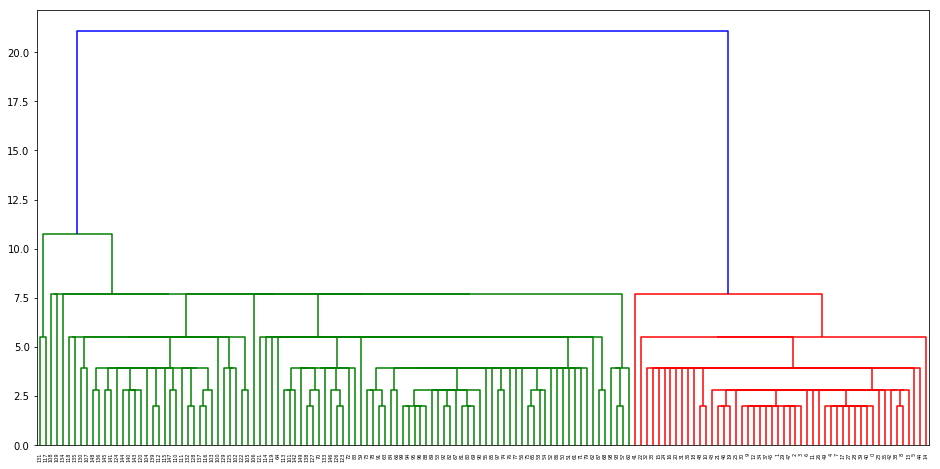

In [602]:
dendrogram(Z, color_threshold = 18)
plt.gcf().set_size_inches(16, 8)
plt.show();

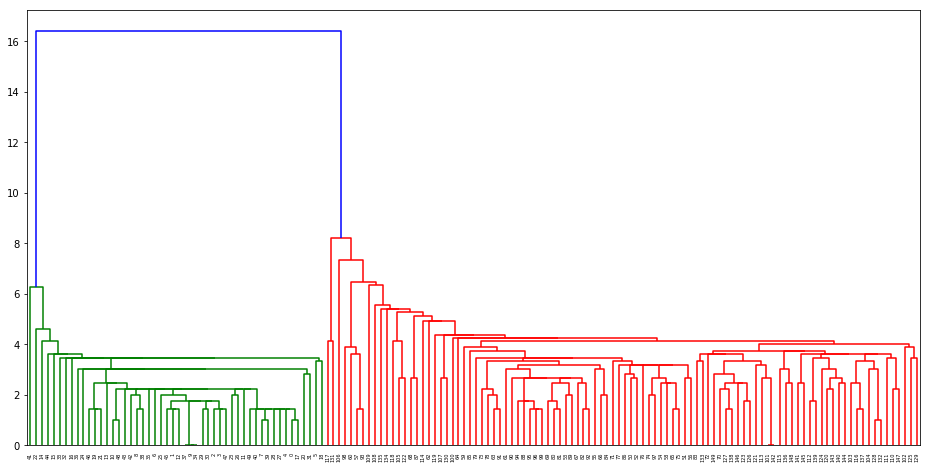

In [581]:
z = linkage(iris, method="single")
z

dendrogram(z)
plt.gcf().set_size_inches(16, 8)
plt.show();

In [582]:
z

array([[  9.        ,  34.        ,   0.        ,   2.        ],
       [ 37.        , 150.        ,   0.        ,   3.        ],
       [101.        , 142.        ,   0.        ,   2.        ],
       [  0.        ,  17.        ,   1.        ,   2.        ],
       [  7.        ,  39.        ,   1.        ,   2.        ],
       [ 10.        ,  48.        ,   1.        ,   2.        ],
       [128.        , 132.        ,   1.        ,   2.        ],
       [  4.        , 153.        ,   1.41421356,   3.        ],
       [ 27.        , 157.        ,   1.41421356,   4.        ],
       [ 28.        , 158.        ,   1.41421356,   5.        ],
       [154.        , 159.        ,   1.41421356,   7.        ],
       [ 40.        , 160.        ,   1.41421356,   8.        ],
       [ 49.        , 161.        ,   1.41421356,   9.        ],
       [ 29.        ,  30.        ,   1.41421356,   2.        ],
       [  3.        ,  47.        ,   1.41421356,   2.        ],
       [  2.        , 164

In [596]:
print(end-start)

0:00:03.139739


In [87]:
a = np.array([[48, 30, 14,  1], [48, 30, 14,  3], [49, 31, 15,  1]])

In [89]:
a.shape
a

array([[48, 30, 14,  1],
       [48, 30, 14,  3],
       [49, 31, 15,  1]])

In [97]:
b = get_point_indices(iris, a)
b

array([12, 45,  9, 34, 37])

In [93]:
iris[b]

array([[48., 30., 14.,  1.],
       [48., 30., 14.,  3.],
       [49., 31., 15.,  1.],
       [49., 31., 15.,  1.],
       [49., 31., 15.,  1.]])

In [100]:
print(iris[9,], iris[34,], iris[37,])

[49. 31. 15.  1.] [49. 31. 15.  1.] [49. 31. 15.  1.]


In [101]:
e = np.array([])

In [109]:
if  e.size:
    print("hi")

In [142]:
np.min(iris)

0.0

In [189]:
### Question 3b - Hierarchical Agglomerative Clustering
# single-linkage clustering: https://en.wikipedia.org/wiki/Single-linkage_clustering

def hac(k, data):
    n = data.shape[0]
    
    # start with each point in its own cluster
    clusters = np.arange(n)
    unique_clusters = len(np.unique(clusters))
    
    while unique_clusters > k:
        min_distances = np.zeros(n)
        min_points = np.zeros(n).astype('int')

        # for each point, find min distance to point not in cluster
        for i in range(n):
            point = data[i,]
            point_cluster = clusters[i]
            distances = np.linalg.norm(point - data, axis = 1)
            diff_cluster_points = np.where(clusters != point_cluster)[0]

            min_points[i] = diff_cluster_points[np.argmin(distances[diff_cluster_points])]
            min_distances[i] = distances[min_points[i]]

        # merge clusters of the two closest points
        point1_idx = np.argmin(min_distances)
        point1 = data[point1_idx,]
        point2_idx = min_points[point1_idx]
        point2 = data[point2_idx,]

        point2_cluster = clusters[point2_idx]
        clusters[np.where(clusters == point2_cluster)[0]] = clusters[point1_idx]

        # update number of clusters
        unique_clusters = len(np.unique(clusters))
    
    return clusters

In [590]:
k = 2
start = datetime.datetime.now()
clusters_hac = hac(k, iris)
end=datetime.datetime.now()
print(end-start)

0:00:00.561841


In [591]:
clusters_hac

array([ 14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,
        14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,
        14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14,
        14,  14,  14,  14,  14,  14,  14,  14,  14,  14,  14, 109, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109,
       109, 109, 109, 109, 109, 109, 109])